# ARI

Nous allons dans ce notebook, déterminer la stabilité dans le temps de notre modèle K-means avec les données RFM, qui est la meilleure méthode de clustering que nous avons obtenu sur notre notebook d'essai.

L'ARI permet de connaitre la "durée de vie", la stabilité dans le temps, d'un modèle avant de le mettre à jour.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score

In [30]:
# importation de la dataframe rfm
rfm_df_ARI = pd.read_csv(r'data/rfm_df_ARI.csv')

In [31]:
rfm_df_ARI

,monetary,frequency,recency
0,1135.20,1,115
1,27.19,1,118
2,689.76,1,541
3,174.48,1,325
4,1181.34,1,292
...,...,...,...
93390,20674.20,1,451
93391,84.58,1,266
93392,112.46,1,572
93393,668.45,1,123


In [32]:
def kmean_time_stability(dataframe, recency_col, n_clusters, jours, ari=True):
    """
    Affiche la stabilité dans le temps

    Entrée :
    - dataframe - unscaled dataframe
    - recency_col - str, la colonne récence
    - n_clusters - int, nombre de clusters
    - ari - bool, choix entre ARI ou AMI

    Sortie :
    - Liste de score
    """
    np.seterr(all='ignore')

    date_init = 365
    date_slipping = 0
    date_lim = date_init
    date_max = dataframe[recency_col].max()

    score = []

    first_year = dataframe[dataframe[recency_col] <= date_init]
    first_year_scaled = StandardScaler().fit_transform(first_year)
    first_year_clustered = cluster.KMeans(n_clusters=n_clusters)
    first_year_clustered.fit(first_year_scaled)

    while date_lim < date_max:

        add_next_month = dataframe[(dataframe[recency_col] >= date_slipping)
                                   & (dataframe[recency_col] <= date_lim)]
        add_next_month_scaled = StandardScaler().fit_transform(add_next_month)
        y_pred = first_year_clustered.predict(add_next_month_scaled)
        y_label = first_year_clustered.fit(add_next_month_scaled).labels_

        if ari == True:
            score.append(adjusted_rand_score(y_pred, y_label))
        else:
            score.append(adjusted_mutual_info_score(y_pred, y_label))

        date_lim += jours
        date_slipping += jours

    return score[::-1]

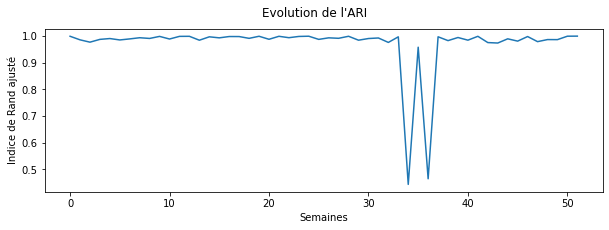

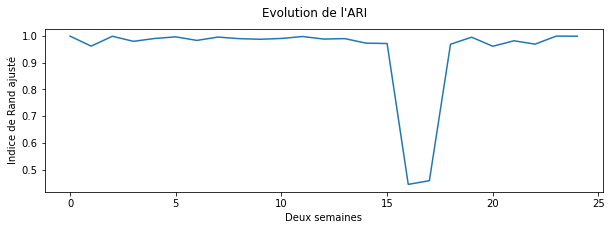

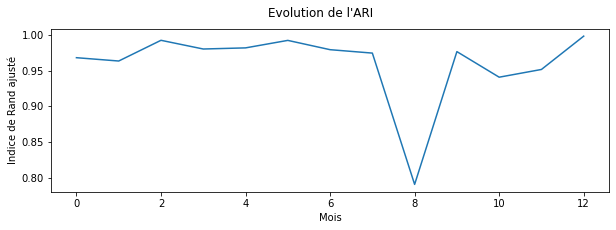

In [33]:
nombre_de_jours = {'Semaines': 7, 'Deux semaines': 15, 'Mois': 30}
for keys, values in nombre_de_jours.items():
    score_ari = kmean_time_stability(rfm_df_ARI,
                                     'recency',
                                     5,
                                     values,
                                     ari=True)
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.plot(range(len(score_ari)), score_ari)
    plt.xlabel(keys)
    plt.ylabel("Indice de Rand ajusté")
    fig.suptitle("Evolution de l'ARI")

Nous pouvons constater que les données doivent être mises à jour tous les 8 mois environ.